<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/10_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 17.7MB/s 
     |████████████████████████████████| 194kB 34.3MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 35.5MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 12.8MB 70.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


NOTE: `ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.` This error can be ignored.


In [ ]:
# !pip install torchtext==0.8.1
# !pip install -U fastbook
# import fastbook
# fastbook.setup_book()

In [ ]:
# !uptime

 15:12:29 up 15 min,  0 users,  load average: 0.92, 0.45, 0.21


NOTE: ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.

In [ ]:
from fastbook import *
from IPython.display import display,HTML

# NLP Deep Dive: RNNs

In <<chapter_intro>> we saw that deep learning can be used to get great results with natural language datasets. Our example relied on using a pretrained language model and fine-tuning it to classify reviews. That example highlighted a difference between transfer learning in NLP and computer vision: in general in NLP the pretrained model is trained on a different task.

**What we call a language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called *self-supervised learning*: we do not need to give labels to our model, just feed it lots and lots of texts**. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to develop an understanding of the English (or other) language. Self-supervised learning can also be used in other domains; for instance, see ["Self-Supervised Learning and Computer Vision"](https://www.fast.ai/2020/01/13/self_supervised/) for an introduction to vision applications. Self-supervised learning is not usually used for the model that is trained directly, but instead is used for pretraining a model used for transfer learning.

> jargon: Self-supervised learning: Training a model using labels that are embedded in the independent variable, rather than requiring external labels. For instance, training a model to predict the next word in a text.

**The language model we used to classify IMDb reviews was pretrained on Wikipedia**. We got great results by directly fine-tuning this language model to a movie review classifier, but with one extra step, we can do even better. The Wikipedia English is slightly different from the IMDb English, so instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the IMDb corpus and then use *that* as the base for our classifier.

Even if our language model knows the basics of the language we are using in the task (e.g., our pretrained model is in English), it helps to get used to the style of the corpus we are targeting. It may be more informal language, or more technical, with new words to learn or different ways of composing sentences. In the case of the IMDb dataset, there will be lots of names of movie directors and actors, and often a less formal style of language than that seen in Wikipedia.

We already saw that with fastai, we can download a pretrained English language model and use it to get state-of-the-art results for NLP classification. (We expect pretrained models in many more languages to be available soon—they might well be available by the time you are reading this book, in fact.) So, why are we learning how to train a language model in detail?

One reason, of course, is that it is helpful to understand the foundations of the models that you are using. But there is another very practical reason, which is that you get even better results if you fine-tune the (sequence-based) language model prior to fine-tuning the classification model. For instance, for **the IMDb sentiment analysis task, the dataset includes 50,000 additional movie reviews that do not have any positive or negative labels attached. Since there are 25,000 labeled reviews in the training set and 25,000 in the validation set, that makes 100,000 movie reviews altogether**. **We can use all of these reviews to fine-tune the pretrained language model, which was trained only on Wikipedia articles; this will result in a language model that is particularly good at predicting the next word of a movie review**.

**This is known as the Universal Language Model Fine-tuning (ULMFit) approach**. The [paper](https://arxiv.org/abs/1801.06146) showed that this extra stage of fine-tuning of the language model, prior to transfer learning to a classification task, resulted in significantly better predictions. Using this approach, we have three stages for transfer learning in NLP, as summarized in <<ulmfit_process>>.

<img alt="Diagram of the ULMFiT process" width="700" caption="The ULMFiT process" id="ulmfit_process" src="https://github.com/fastai/fastbook/blob/master/images/att_00027.png?raw=1">

We'll now explore how to apply a neural network to this language modeling problem, using the concepts introduced in the last two chapters. But before reading further, pause and think about how *you* would approach this.

## Text Preprocessing

It's not at all obvious how we're going to use what we've learned so far to build a language model. Sentences can be different lengths, and documents can be very long. So, how can we predict the next word of a sentence using a neural network? Let's find out!

We've already seen how categorical variables can be used as independent variables for a neural network. The approach we took for a single categorical variable was to:

1. Make a list of all possible levels of that categorical variable (we'll call this list the *vocab*).
1. Replace each level with its index in the vocab.
1. Create an embedding matrix for this containing a row for each level (i.e., for each item of the vocab).
1. Use this embedding matrix as the first layer of a neural network. (A dedicated embedding matrix can take as inputs the raw vocab indexes created in step 2; this is equivalent to but faster and more efficient than a matrix that takes as input one-hot-encoded vectors representing the indexes.)

We can do nearly the same thing with text! What is new is the idea of a sequence. **First we concatenate all of the documents in our dataset into one big long string and split it into words, giving us a very long list of words (or "tokens"). Our independent variable will be the sequence of words starting with the first word in our very long list and ending with the second to last, and our dependent variable will be the sequence of words starting with the second word and ending with the last word**. 

Our vocab will consist of a mix of common words that are already in the vocabulary of our pretrained model and new words specific to our corpus (cinematographic terms or actors names, for instance). Our embedding matrix will be built accordingly: for words that are in the vocabulary of our pretrained model, we will take the corresponding row in the embedding matrix of the pretrained model; but for new words we won't have anything, so we will just initialize the corresponding row with a random vector.

Each of the steps necessary to create a language model has jargon associated with it from the world of natural language processing, and fastai and PyTorch classes available to help. The steps are:

- **Tokenization**: Convert the text into a list of words (or characters, or substrings, depending on the granularity of your model)
- **Numericalization**: Make a list of all of the unique words that appear (the vocab), and convert each word into a number, by looking up its index in the vocab
- **Language model data loader creation**: fastai provides an `LMDataLoader` class which automatically handles creating a dependent variable that is offset from the independent variable by one token. It also handles some important details, such as how to shuffle the training data in such a way that the dependent and independent variables maintain their structure as required
- **Language model creation**: We need a special kind of model that does something we haven't seen before: handles input lists which could be arbitrarily big or small. There are a number of ways to do this; in this chapter we will be using a *recurrent neural network* (RNN). We will get to the details of these RNNs in the <<chapter_nlp_dive>>, but for now, you can think of it as just another deep neural network.

Let's take a look at how each step works in detail.

### Tokenization

When we said "convert the text into a list of words," we left out a lot of details. For instance, what do we do with punctuation? How do we deal with a word like "don't"? Is it one word, or two? What about long medical or chemical words? Should they be split into their separate pieces of meaning? How about hyphenated words? What about languages like German and Polish where we can create really long words from many, many pieces? What about languages like Japanese and Chinese that don't use bases at all, and don't really have a well-defined idea of *word*?

Because there is no one correct answer to these questions, there is no one approach to tokenization. There are three main approaches:

- **Word-based**: Split a sentence on spaces, as well as applying language-specific rules to try to separate parts of meaning even when there are no spaces (such as turning "don't" into "do n't"). Generally, punctuation marks are also split into separate tokens.
- **Subword based**: Split words into smaller parts, based on the most commonly occurring substrings. For instance, "occasion" might be tokenized as "o c ca sion."
- **Character-based**: Split a sentence into its individual characters.

We'll be looking at word and subword tokenization here, and we'll leave character-based tokenization for you to implement in the questionnaire at the end of this chapter.

> jargon: token: One element of a list created by the tokenization process. It could be a word, part of a word (a _subword_), or a single character.

### Word Tokenization with fastai

Rather than providing its own tokenizers, fastai instead provides a consistent interface to a range of tokenizers in external libraries. Tokenization is an active field of research, and new and improved tokenizers are coming out all the time, so the defaults that fastai uses change too. However, the API and options shouldn't change too much, since fastai tries to maintain a consistent API even as the underlying technology changes.

Let's try it out with the IMDb dataset that we used in <<chapter_intro>>:

In [ ]:
from fastai.text.all import *
path = untar_data(URLs.IMDB, dest='/content/')

In [ ]:
path

Path('/content/imdb')

We'll need to grab the text files in order to try out a tokenizer. Just like `get_image_files`, which we've used many times already, gets all the image files in a path, `get_text_files` gets all the text files in a path. We can also optionally pass `folders` to restrict the search to a particular list of subfolders:

In [ ]:
# getting all the text files in a path.
files = get_text_files(path, folders = ['train', 'test', 'unsup'])

In [ ]:
??get_text_files

NOTE: the directory folder `unsup` means unsupervised; it holds movie reviews that do no have a rating attached to it. There are 50000 records unlabeled in that folder. Whereas, the train and test folders have 25000 records of movie reviews labeled each. Bringing to a total of 100000 movie reviews.  And we will use all these records to fine-tuned the pretrained language model which will then be particularly good at predicting the next word of a movie review.

Now it relates to **semi-supervised learning**, that is can we do something useful with unlabeled data?. In this case, we add this corpus to our language model because its functions is to predict the next word, it does not care whether the movie review is positivie or negative.

So, now we have 25000 movie reviews in `train`, 25000 movie reviews in `test` and 50000 movie reviews in `unsup`. So, by adding the `unsup` folder, we have twice as much data to build a language model with.

Here's a review that we'll tokenize (we'll just print the start of it here to save space):

In [ ]:
# example of a movie review (first 75 characters) that will be tokenized.
txt = files[0].open().read(); txt[:75]

'Tenshu is imprisoned and sentenced to death. When he survives electrocution'

As we write this book, **the default English word tokenizer for fastai uses a library called *spaCy***. It has a sophisticated rules engine with special rules for URLs, individual special English words, and much more. Rather than directly using `SpacyTokenizer`, however, we'll use `WordTokenizer`, since that will always point to fastai's current default word tokenizer (which may not necessarily be spaCy, depending when you're reading this).

Let's try it out. We'll use fastai's `coll_repr(collection, n)` function to display the results. This displays the first *`n`* items of *`collection`*, along with the full size—it's what `L` uses by default. Note that fastai's tokenizers take a collection of documents to tokenize, so we have to wrap `txt` in a list:

In [ ]:
# calling the tokenizer
spacy = WordTokenizer()
# applying the tokenizer to the text
toks = first(spacy([txt]))
# displaying the results of the tokenization
print(coll_repr(toks, 30))

(#260) ['Tenshu','is','imprisoned','and','sentenced','to','death','.','When','he','survives','electrocution','the','government','officials','give','him','a','choice','to','either','be','electrocute','at','a','greater','degree','or','agree','to'...]


NOTE: `WordTokenizer` is a fastai tokenizer (which currently is `spaCy`).  The `WordTokenizer` will return a generator so we need to call first (returning the first element of the generator) to be able to display the result. 

`coll_repr` collection representation displaying the tokenization results.

NOTE: As you see, spaCy has mainly just separated out the words and punctuation. But it does something else here too: it has split "it's" into "it" and "'s". That makes intuitive sense; these are separate words, really. Tokenization is a surprisingly subtle task, when you think about all the little details that have to be handled. Fortunately, spaCy handles these pretty well for us—for instance, here we see that "." is separated when it terminates a sentence, but not in an acronym or number:

In [ ]:
# spaCy handling correctly acronym, decimal point and the end of a sentence.
first(spacy(['The U.S. dollar $1 is $1.00.']))

(#9) ['The','U.S.','dollar','$','1','is','$','1.00','.']

fastai then adds some additional functionality to the tokenization process with the `Tokenizer` class:

In [ ]:
# fastai additions to the tokenizer process
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 31))

(#302) ['xxbos','xxmaj','tenshu','is','imprisoned','and','sentenced','to','death','.','xxmaj','when','he','survives','electrocution','the','government','officials','give','him','a','choice','to','either','be','electrocute','at','a','greater','degree','or'...]


NOTE: fastai provides a tokenizer wrapper which add additional tokens such as for instance `xxbos` and `xxeos` for beginning and end of stream. Also, capital letters are turned into lower case letters (`xxmaj`), ... etc

Notice that there are now some tokens that start with the characters "xx", which is not a common word prefix in English. These are *special tokens*.

For example, the first item in the list, `xxbos`, is a special token that indicates the start of a new text ("BOS" is a standard NLP acronym that means "beginning of stream"). By recognizing this start token, the model will be able to learn it needs to "forget" what was said previously and focus on upcoming words.

These special tokens don't come from spaCy directly. They are there because fastai adds them by default, by applying a number of rules when processing text. **These rules are designed to make it easier for a model to recognize the important parts of a sentence**. In a sense, we are translating the original English language sequence into a simplified tokenized language—a language that is designed to be easy for a model to learn.

For instance, the rules will replace a sequence of four exclamation points with a special *repeated character* token, followed by the number four, and then a single exclamation point. In this way, **the model's embedding matrix can encode information about general concepts such as repeated punctuation rather than requiring a separate token for every number of repetitions of every punctuation mark**. Similarly, a capitalized word will be replaced with a special capitalization token, followed by the lowercase version of the word. This way, the embedding matrix only needs the lowercase versions of the words, saving compute and memory resources, but can still learn the concept of capitalization.

Here are some of the main special tokens you'll see:

- `xxbos`:: Indicates the beginning of a text (here, a review) (beginning of stream)
- `xxmaj`:: Indicates the next word begins with a capital (since we lowercased everything)
- `xxunk`:: Indicates the word is unknown

To see the rules that were used, you can check the default rules:

In [ ]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html>,
 <function fastai.text.core.replace_rep>,
 <function fastai.text.core.replace_wrep>,
 <function fastai.text.core.spec_add_spaces>,
 <function fastai.text.core.rm_useless_spaces>,
 <function fastai.text.core.replace_all_caps>,
 <function fastai.text.core.replace_maj>,
 <function fastai.text.core.lowercase>]

As always, you can look at the source code of each of them in a notebook by typing:

```
??replace_rep
```

Here is a brief summary of what each does:

- `fix_html`:: Replaces special HTML characters with a readable version (IMDb reviews have quite a few of these)
- `replace_rep`:: Replaces any character repeated three times or more with a special token for repetition (`xxrep`), the number of times it's repeated, then the character
- `replace_wrep`:: Replaces any word repeated three times or more with a special token for word repetition (`xxwrep`), the number of times it's repeated, then the word
- `spec_add_spaces`:: Adds spaces around / and #
- `rm_useless_spaces`:: Removes all repetitions of the space character
- `replace_all_caps`:: Lowercases a word written in all caps and adds a special token for all caps (`xxup`) in front of it
- `replace_maj`:: Lowercases a capitalized word and adds a special token for capitalized (`xxmaj`) in front of it
- `lowercase`:: Lowercases all text and adds a special token at the beginning (`xxbos`) and/or the end (`xxeos`)

Let's take a look at a few of them in action:

In [ ]:
coll_repr(tkn('&copy;   Fast.ai www.fast.ai/INDEX'), 31)

"(#11) ['xxbos','©','xxmaj','fast.ai','xxrep','3','w','.fast.ai','/','xxup','index']"

Now let's take a look at how subword tokenization would work.

### Subword Tokenization

In addition to the *word tokenization* approach seen in the last section, another popular tokenization method is *subword tokenization*. Word tokenization relies on an assumption that spaces provide a useful separation of components of meaning in a sentence. However, this assumption is not always appropriate. For instance, consider this sentence: 我的名字是郝杰瑞 ("My name is Jeremy Howard" in Chinese). That's not going to work very well with a word tokenizer, because there are no spaces in it! Languages like Chinese and Japanese don't use spaces, and in fact they don't even have a well-defined concept of a "word." There are also languages, like Turkish and Hungarian, that can add many subwords together without spaces, creating very long words that include a lot of separate pieces of information.

To handle these cases, it's generally best to use subword tokenization. This proceeds in two steps:

1. Analyze a corpus of documents to find the **most commonly occurring groups of letters**. These become the vocab.
2. Tokenize the corpus using this vocab of *subword units*.

Let's look at an example. For our corpus, we'll use the first 2,000 movie reviews:

In [ ]:
# getting the first 2000 movie reviews for subword example
txts = L(o.open().read() for o in files[:2000])

We instantiate our tokenizer, passing in the size of the vocab we want to create, and then we need to "train" it. That is, we need to have it read our documents and find the common sequences of characters to create the vocab. This is done with `setup`. As we'll see shortly, `setup` is a special fastai method that is called automatically in our usual data processing pipelines. Since we're doing everything manually at the moment, however, we have to call it ourselves. Here's a function that does these steps for a given vocab size, and shows an example output:

In [ ]:
# function calling the SubWordTokenizer
def subword(sz):
    sp = SubwordTokenizer(vocab_sz=sz)
    sp.setup(txts)
    return ' '.join(first(sp([txt]))[:40])

NOTE: the default SubwordTokenizer uses SentenPiece. `setup`, transforms in fastai will call `setup` to do some initialization as per the transform being used such as, in this case, `SubwordTokenizer`. So, `sp.setup(txts)` will train the `SubwordTokenizer` to get the most commonly occurring groups of letters.


Let's try it out:

In [ ]:
# calling the subword function with a vocab size of 1000
subword(1000)

'▁T en sh u ▁is ▁imp ri son ed ▁and ▁ s ent ence d ▁to ▁death . ▁When ▁he ▁su r v ive s ▁e le c t ro cu tion ▁the ▁go ver n ment ▁off ic ial'

NOTE: When using fastai's subword tokenizer, the special character `▁` represents a space character in the original text.

In [ ]:
len(subword(1000))

139

**If we use a smaller vocab, then each token will represent fewer characters, and it will take more tokens to represent a sentence**:

In [ ]:
# calling the subword function with a vocab size of 200
subword(200)

'▁ T en s h u ▁is ▁ i m p ri s on ed ▁and ▁ s ent en c ed ▁to ▁ d e a th . ▁ W h en ▁h e ▁ s ur v i'

NOTE: with a smaller vocab, more tokens are generated to create a sentence.

In [ ]:
len(subword(200))

98

On the other hand, **if we use a larger vocab, then most common English words will end up in the vocab themselves, and we will not need as many to represent a sentence**:

In [ ]:
# calling the subword function with a vocab size of 10000
subword(10000)

'▁Ten s hu ▁is ▁imp ri son ed ▁and ▁sentence d ▁to ▁death . ▁When ▁he ▁survive s ▁elect ro cut ion ▁the ▁government ▁official s ▁give ▁him ▁a ▁choice ▁to ▁either ▁be ▁elect ro cut e ▁at ▁a ▁great'

NOTE: with a larger vocab, less tokens are generated.

In [ ]:
len(subword(10000))

194

**Picking a subword vocab size represents a compromise: a larger vocab means fewer tokens per sentence, which means faster training, less memory, and less state for the model to remember; but on the downside, it means larger embedding matrices, which require more data to learn**.

Overall, subword tokenization provides a way to easily scale between **character tokenization (i.e., using a small subword vocab)** and **word tokenization (i.e., using a large subword vocab)**, and handles every human language without needing language-specific algorithms to be developed. It can even handle other "languages" such as genomic sequences or MIDI music notation! For this reason, in the last year its popularity has soared, and it seems likely to become the most common tokenization approach (it may well already be, by the time you read this!).

Once our texts have been split into tokens, we need to convert them to numbers. We'll look at that next.

### Numericalization with fastai

***Numericalization* is the process of mapping tokens to integers**. The steps are basically identical to those necessary to create a `Category` variable, such as the dependent variable of digits in MNIST:

1. Make a list of all possible levels of that categorical variable (the vocab).
1. Replace each level with its index in the vocab.

Let's take a look at this in action on the word-tokenized text we saw earlier:

In [ ]:
toks = tkn(txt)
print(coll_repr(tkn(txt), 31))

(#302) ['xxbos','xxmaj','tenshu','is','imprisoned','and','sentenced','to','death','.','xxmaj','when','he','survives','electrocution','the','government','officials','give','him','a','choice','to','either','be','electrocute','at','a','greater','degree','or'...]


Just like with `SubwordTokenizer`, we need to call `setup` on `Numericalize`; this is how we create the vocab. That means we'll need our tokenized corpus first. Since tokenization takes a while, it's done in parallel by fastai; but for this manual walkthrough, we'll use a small subset:

In [ ]:
# getting 200 movie reviews
toks200 = txts[:200].map(tkn)
# example of one
toks200[0]

(#302) ['xxbos','xxmaj','tenshu','is','imprisoned','and','sentenced','to','death','.'...]

We can pass this to `setup` to create our vocab:

In [ ]:
num = Numericalize()
num.setup(toks200)
# showing a representation of a collection (L class)
coll_repr(num.vocab,20)

"(#2136) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the',',','.','and','a','of','to','is','it','in','i'...]"

NOTE: The vocabulary thus generated, starts with the fastai special tokens `xx..`, then, we have the english token in order of frequency. Maximum embedding size is 60000, "out of the bag words" are treated with an `xxunk` (unknown) word token. Fastai uses a flag `min_freq=3` meaning any work appearing less than 3 times is replaced with an `xxunk` token. This limit is useful to avoid having an overly large embedding matrix.  This limit ia also better for computational performance.

Our special rules tokens appear first, and then every word appears once, in frequency order. The defaults to `Numericalize` are `min_freq=3,max_vocab=60000`. `max_vocab=60000` results in fastai replacing all words other than the most common 60,000 with a special *unknown word* token, `xxunk`. This is useful to avoid having an overly large embedding matrix, since that can slow down training and use up too much memory, and can also mean that there isn't enough data to train useful representations for rare words. However, this last issue is better handled by setting `min_freq`; the default `min_freq=3` means that any word appearing less than three times is replaced with `xxunk`.

fastai can also numericalize your dataset using a vocab that you provide, by passing a list of words as the `vocab` parameter.

Once we've created our `Numericalize` object, we can use it as if it were a function:

In [ ]:
# tensor of integers
nums = num(toks)[:20]; nums

TensorText([  2,   8,   0,  16,   0,  12,   0,  15, 336,  11,   8,  62,  38,   0,   0,   9,   0,   0, 203,  87])

NOTE: `2` represents the token `xxbos` and `8` represents `xxmaj` for example.

This time, our tokens have been converted to a tensor of integers that our model can receive. We can check that they map back to the original text:

In [ ]:
# mapping integers to texts
' '.join(num.vocab[o] for o in nums)

'xxbos xxmaj xxunk is xxunk and xxunk to death . xxmaj when he xxunk xxunk the xxunk xxunk give him'

Now that we have numbers, we need to put them in batches for our model.

### Putting Our Texts into Batches for a Language Model

When dealing with images, we needed to resize them all to the same height and width before grouping them together in a mini-batch so they could stack together efficiently in a single tensor. Here it's going to be a little different, because one cannot simply resize text to a desired length. Also, we want our language model to read text in order, so that it can efficiently predict what the next word is. **This means that each new batch should begin precisely where the previous one left off**.

Suppose we have the following text:

> : In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while.

The tokenization process will add special tokens and deal with punctuation to return this text:

> : xxbos xxmaj in this chapter , we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface . xxmaj first we will look at the processing steps necessary to convert text into numbers and how to customize it . xxmaj by doing this , we 'll have another example of the preprocessor used in the data block xxup api . \n xxmaj then we will study how we build a language model and train it for a while .

We now have 90 tokens, separated by spaces. Let's say we want a batch size of 6. We need to break this text into 6 contiguous parts of length 15:

In [ ]:
# Creating batches
stream = "In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while."
tokens = tkn(stream)
# batch size and sequence length
bs,seq_len = 6,15
d_tokens = np.array([tokens[i*seq_len:(i+1)*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter,",",we,will,go,back,over,the,example,of,classifying
movie,reviews,we,studied,in,chapter,1,and,dig,deeper,under,the,surface,.,xxmaj
first,we,will,look,at,the,processing,steps,necessary,to,convert,text,into,numbers,and
how,to,customize,it,.,xxmaj,by,doing,this,",",we,'ll,have,another,example
of,the,preprocessor,used,in,the,data,block,xxup,api,.,\n,xxmaj,then,we
will,study,how,we,build,a,language,model,and,train,it,for,a,while,.


NOTE: result: 6 contiguous parts of length 15.

In a perfect world, we could then give this one batch to our model. But that approach doesn't scale, because outside of this toy example it's unlikely that a single batch containing all the texts would fit in our GPU memory (here we have 90 tokens, but all the IMDb reviews together give several million).

So, we need to divide this array more finely into **subarrays of a fixed sequence length**. It is important to maintain order within and across these subarrays, because we will use a model that maintains a state so that it remembers what it read previously when predicting what comes next. 

Going back to our previous example with 6 batches of length 15, if we chose a sequence length of 5, that would mean we first feed the following array:

In [ ]:
#hide_input
# batch size 6, sequence length 5 - 6x5
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15:i*15+seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter
movie,reviews,we,studied,in
first,we,will,look,at
how,to,customize,it,.
of,the,preprocessor,used,in
will,study,how,we,build


NOTE: **We are splitting up horizontally**. This is our first mini-batch. Each row are independent. The first row of this batch connects to the first row of the second mini-batch and so on.

Then this one:

In [ ]:
#hide_input
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+seq_len:i*15+2*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

",",we,will,go,back
chapter,1,and,dig,deeper
the,processing,steps,necessary,to
xxmaj,by,doing,this,","
the,data,block,xxup,api
a,language,model,and,train


And finally:

In [ ]:
#hide_input
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+10:i*15+15] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

over,the,example,of,classifying
under,the,surface,.,xxmaj
convert,text,into,numbers,and
we,'ll,have,another,example
.,\n,xxmaj,then,we
it,for,a,while,.


Going back to our movie reviews dataset, **the first step is to transform the individual texts into a stream by concatenating them together**. As with images, it's best to **randomize the order of the inputs**, so at the beginning of each epoch we will shuffle the entries to make a new stream (**we shuffle the order of the documents**, not the order of the words inside them, or the texts would not make sense anymore!).

We then **cut this stream into a certain number of batches** (which is our *batch size*). For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens. What is important is that we preserve the order of the tokens (so from 1 to 5,000 for the first mini-stream, then from 5,001 to 10,000...), because we want the model to read continuous rows of text (as in the preceding example). **An `xxbos` token is added at the start of each during preprocessing, so that the model knows when it reads the stream when a new entry is beginning**.

So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

This is all done behind the scenes by the fastai library when we create an `LMDataLoader`. We do this by first applying our `Numericalize` object to the tokenized texts:

In [ ]:
# numericalization
nums200 = toks200.map(num)

and then passing that to `LMDataLoader`:

In [ ]:
# creating a data loader
dl = LMDataLoader(nums200)

Let's confirm that this gives the expected results, by grabbing the first batch:

In [ ]:
# grabbing a first batch
x,y = first(dl)
x.shape,y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

NOTE: 64 is the default batch size and 72 is the default sequence length.

and then looking at the first row of the independent variable, which should be the start of the first text:

In [ ]:
# Independent variable - looking at the first row of the vocab
' '.join(num.vocab[o] for o in x[0][:20])

'xxbos xxmaj xxunk is xxunk and xxunk to death . xxmaj when he xxunk xxunk the xxunk xxunk give him'

The dependent variable is the same thing offset by one token:

In [ ]:
# Dependent the variable offset by one token - getting the next word
' '.join(num.vocab[o] for o in y[0][:20])

'xxmaj xxunk is xxunk and xxunk to death . xxmaj when he xxunk xxunk the xxunk xxunk give him a'

NOTE: the dependent variable has an offset of one.

This concludes all the preprocessing steps we need to apply to our data. We are now ready to train our text classifier.

## Training a Text Classifier

As we saw at the beginning of this chapter, there are two steps to training a state-of-the-art text classifier using transfer learning: 
- first we need to fine-tune our language model pretrained on Wikipedia to the corpus of IMDb reviews, and then 
- we can use that model to train a classifier.

As usual, let's start with assembling our data.

### Language Model Using DataBlock

**fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`**. All of the arguments that can be passed to `Tokenize` and `Numericalize` can also be passed to `TextBlock`. In the next chapter we'll discuss the easiest ways to run each of these steps separately, to ease debugging—but you can always just debug by running them manually on a subset of your data as shown in the previous sections. And don't forget about `DataBlock`'s handy `summary` method, which is very useful for debugging data issues.

Here's how we use `TextBlock` to create a language model, using fastai's defaults:

In [ ]:
# getting the IMDB text files
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

# creating a language model data loader
# using a TextBlock to create a language model using fastai's defaults
dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

[datablock api doc](https://docs.fast.ai/tutorial.datablock.html)


NOTE: language models can use a lot of GPU, so you may need to decrease batchsize here (`bs`). `bs` decreased from 128 to 64 for this colab session.  You might also want to decrease the sequence length.

One thing that's different to previous types we've used in `DataBlock` is that we're not just using the class directly (i.e., `TextBlock(...)`, but instead are calling a *class method*. A class method is a Python method that, as the name suggests, belongs to a *class* rather than an *object*. (Be sure to search online for more information about class methods if you're not familiar with them, since they're commonly used in many Python libraries and applications; we've used them a few times previously in the book, but haven't called attention to them.) The reason that `TextBlock` is special is that setting up the numericalizer's vocab can take a long time (we have to read and tokenize every document to get the vocab). To be as efficient as possible it performs a few optimizations: 

- **It saves the tokenized documents in a temporary folder, so it doesn't have to tokenize them more than once**
- **It runs multiple tokenization processes in parallel, to take advantage of your computer's CPUs**

We need to tell `TextBlock` how to access the texts, so that it can do this initial preprocessing—that's what `from_folder` does.

`show_batch` then works in the usual way:

In [ ]:
# showing two batch items
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos during eddie murphy 's stand up a women from the audience yells at eddie and a man from the audience responds . what is said is , , women - xxup do xxup mr xxup rob ( this is a character from xxmaj saturday night live ) , the man responds with xxup shut xxup up xxup bitch . unlike the previous post saying the women yelled do gumby , this is incorrect , although the post - er","during eddie murphy 's stand up a women from the audience yells at eddie and a man from the audience responds . what is said is , , women - xxup do xxup mr xxup rob ( this is a character from xxmaj saturday night live ) , the man responds with xxup shut xxup up xxup bitch . unlike the previous post saying the women yelled do gumby , this is incorrect , although the post - er said"
1,", instead of a saccharine watered down version that is a total waste of time and money , is not easy ! xxmaj good luck ! xxmaj enjoy this film , but remember … it is only fantasy ! xxbos xxmaj after their very wealthy father of the xxmaj whitman family dies three very wealthy brothers set off to xxmaj india to find their wealthy self - indulgent mother who is undergoing some mental catharsis guilt trip by acting as","instead of a saccharine watered down version that is a total waste of time and money , is not easy ! xxmaj good luck ! xxmaj enjoy this film , but remember … it is only fantasy ! xxbos xxmaj after their very wealthy father of the xxmaj whitman family dies three very wealthy brothers set off to xxmaj india to find their wealthy self - indulgent mother who is undergoing some mental catharsis guilt trip by acting as a"


NOTE: `show_batch` denumericalize the text.  Also, in the second column `text_` we see our dependent variable offset by one. 

Now that our data is ready, we can fine-tune the pretrained language model.

### Fine-Tuning the Language Model

**To convert the integer word indices into activations that we can use for our neural network, we will use embeddings, just like we did for collaborative filtering and tabular modeling**. Then we'll feed those embeddings into a *recurrent neural network* (RNN), using an architecture called *AWD-LSTM* (we will show you how to write such a model from scratch in <<chapter_nlp_dive>>). As we discussed earlier, the embeddings in the pretrained model are merged with random embeddings added for words that weren't in the pretraining vocabulary. This is handled automatically inside `language_model_learner`:

In [ ]:
# creating a language model learner
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

NOTE: [fastai learner doc](https://docs.fast.ai/learner.html) The learner will learn to  predict what is the next word in a movie review.
- `Perplexity()`: perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.
- mixed precision training `.to_fp16()` speeds up the training.

NOTE: A language model learns to predict what word comes next in a sentence. And to predict the next word in a sentence you need to know quite a lot about English (assuming it is in English) and quite a lot about word knowledge.

For instance:
- I like to eat a hot ??? (dog)
- It is a hot ??? (day)

**The loss function used by default is cross-entropy loss, since we essentially have a classification problem** (the different categories being the words in our vocab). **The *perplexity* metric used here is often used in NLP for language models: it is the exponential of the loss** (i.e., `torch.exp(cross_entropy)`). We  also include the **accuracy metric, to see how many times our model is right when trying to predict the next word**, since cross-entropy (as we've seen) is both hard to interpret, and tells us more about the model's confidence than its accuracy.

Let's go back to the process diagram from the beginning of this chapter. The first arrow has been completed for us and made available as a pretrained model in fastai, and we've just built the `DataLoaders` and `Learner` for the second stage. Now we're ready to fine-tune our language model!

<img alt="Diagram of the ULMFiT process" width="450" src="https://github.com/fastai/fastbook/blob/master/images/att_00027.png?raw=1">

It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process. Since `fine_tune` doesn't do that for us, we'll use `fit_one_cycle`. **Just like `cnn_learner`, `language_model_learner` automatically calls `freeze` when using a pretrained model (which is the default), so this will only train the embeddings (the only part of the model that contains randomly initialized weights—i.e., embeddings for words that are in our IMDb vocab, but aren't in the pretrained model vocab)**:

In [ ]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60008, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60008, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60008, bias=True)
    (output_dp): RNNDropout()
  )
)

In [ ]:
# fine tuning the language model for IMDB
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.013922,3.906585,0.299860,49.728813,29:53


CPU times: user 21min 4s, sys: 9min 1s, total: 30min 5s
Wall time: 29min 53s


NOTE: The language model learner is only going to train the new embeddings, that is the part of the model that contains the randomly initialized weights; embedding for words that are in our IMDB vocab and are not in the pretained model vocab.  After one epoch, we get an accuracy of about 30%, nice! it means under a 3rd of a time our model is predicting the next word of a string.

This model takes a while to train, so it's a good opportunity to talk about saving intermediary results. 

### Saving and Loading Models

You can easily save the state of your model like so:

In [ ]:
# saving the state of your model - epoch 1
learn.save('1epoch')

Path('/content/imdb/models/1epoch.pth')

In [ ]:
# saving the model to gdrive
model_save_name = '1epoch.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(learn.state_dict(), path)

This will create a file in `learn.path/models/` named *1epoch.pth*. If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [ ]:
# loading the state of your model for epoch 1
learn = learn.load('1epoch')

In [ ]:
NOTE: before loading the model, make sure that the learner has been created.

In [ ]:
# loading the model from gdrive
model_save_name = '1epoch.pth'
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.load_state_dict(torch.load(path))

<All keys matched successfully>

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:

In [ ]:
# fine tuning the model after unfreezing
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.179487,4.127365,0.298322,62.014278,12:55
1,3.904268,3.865157,0.315461,47.710781,12:49
2,3.747975,3.741694,0.324483,42.169373,12:48
3,3.664353,3.678273,0.329661,39.577972,13:04
4,3.568419,3.634495,0.333824,37.882729,12:39
5,3.496644,3.607989,0.336497,36.891800,12:42
6,3.417458,3.591917,0.338646,36.303596,12:54
7,3.358779,3.583853,0.340059,36.012047,12:36
8,3.313330,3.585232,0.340234,36.061733,12:45
9,3.286820,3.588133,0.340094,36.166492,12:42


NOTE: after 10 epochs, we get an accuracy of almost 34%!

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [ ]:
# saving the fine tuned model - the encoder
# saving all of our model except the final layer converting activations to probabilities
learn.save_encoder('finetuned')

NOTE: after the fine tuning, all we need to do is to save the encoder.  We will not need the final layer that leads to prediction. We need to save only the "body" of the model.  In NLP, we use the term encoder.

In [ ]:
# saving the model to gdrive
model_save_name = 'finetuned.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(learn.state_dict(), path)

In [ ]:
# loading the model from gdrive
model_save_name = 'finetuned.pth'
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.load_state_dict(torch.load(path))

<All keys matched successfully>

NOTE: for our next step which is text classification, we do not care to get the final layer which gives us the next word (the decoding part), we just need the encoding part.

> jargon: Encoder: The model not including the task-specific final layer(s). This term means much the same thing as _body_ when applied to vision CNNs, but "encoder" tends to be more used for NLP and generative models.

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### Text Generation

Before we move on to fine-tuning the classifier, let's quickly try something different: using our model to generate random reviews. Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [ ]:
# predicting the next sentence 
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
??learn.predict

NOTE: in sampling, `temperature` is a parameter allowing for more or less randomness in predictions.  Lower temperature setting equates to more confident, conservative network. Higher temperature setting equates to more excited, random network (and more mistakes)

In [ ]:
print("\n".join(preds))

i liked this movie because it begins with David Thriller and Chris Blink ( james Born ) in a London expectations on the night of the opening . It 's the idea of the plot coming to mind
i liked this movie because it looks like a documentary to show how a young woman who has high euro variety life in a family is not really so . That 's why i was sucked into the game . All the parts


NOTE: Good job! our fined tuned langage model is quite good at inventing language, even with a very simple approach.

As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so we don't get exactly the same review twice. Our model doesn't have any programmed knowledge of the structure of a sentence or grammar rules, yet it has clearly learned a lot about English sentences: we can see it capitalizes properly (***I* is just transformed to *i*** **because our rules require two characters or more to consider a word as capitalized**, **so it's normal to see it lowercased) and is using consistent tense**. The general review makes sense at first glance, and it's only if you read carefully that you can notice something is a bit off. Not bad for a model trained in a couple of hours! 

But our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

### Creating the Classifier DataLoaders

We're now moving from language model fine-tuning to classifier fine-tuning. **To recap, a language model predicts the next word of a document**, so it doesn't need any external labels. **A classifier, however, predicts some external label—in the case of IMDb, it's the sentiment of a document**.

This means that the structure of our `DataBlock` for NLP classification will look very familiar. It's actually nearly the same as we've seen for the many image classification datasets we've worked with:

In [ ]:
path='/content/imdb'

In [ ]:
# NLP text classification
dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path, path=path, bs=128, seq_len=72)

Just like with image classification, `show_batch` shows the dependent variable (sentiment, in this case) with each independent variable (movie review text):

In [ ]:
# show batch with the dependent variable (sentiment)
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love story is an interesting one , however . xxmaj kate xxmaj winslett is wonderful as xxmaj rose , an aristocratic young lady betrothed by xxmaj cal ( billy xxmaj zane ) . xxmaj early on the voyage xxmaj rose meets xxmaj jack ( leonardo dicaprio ) , a lower class artist on his way to xxmaj america after winning his ticket aboard xxmaj titanic in a poker game . xxmaj if he wants something , he goes and gets it",pos
2,"xxbos xxrep 3 * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . xxrep 3 * \n\n xxmaj before i begin , xxmaj i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that - you - fall - over - laughing movies . xxmaj if you 're in a lighthearted mood and need a very hearty laugh , this is the movie for you . xxmaj now without further ado , my review : \n\n xxmaj this movie was found in a bargain bin at wal - mart . xxmaj that should be the first clue as to how good of a movie it is . xxmaj secondly , it stars the lame action",neg


Looking at the `DataBlock` definition, every piece is familiar from previous data blocks we've built, with two important exceptions:

- **`TextBlock.from_folder` no longer has the `is_lm=True` parameter.**
- **We pass the `vocab` we created for the language model fine-tuning.**

The reason that we pass the `vocab` of the language model is to make sure we use the same correspondence of token to index. Otherwise the embeddings we learned in our fine-tuned language model won't make any sense to this model, and the fine-tuning step won't be of any use.

**By passing `is_lm=False` (or not passing `is_lm` at all, since it defaults to `False`) we tell `TextBlock` that we have regular labeled data, rather than using the next tokens as labels.** There is one challenge we have to deal with, however, which is to do with collating multiple documents into a mini-batch. Let's see with an example, by trying to create a mini-batch containing the first 10 documents. First we'll numericalize them:

In [ ]:
# getting the first 10 movie reviews and numericalize them.
nums_samp = toks200[:10].map(num)

Let's now look at how many tokens each of these 10 movie reviews have:

In [ ]:
# looking at the token length for the first 10 movie reviews
nums_samp.map(len)

(#10) [302,225,184,279,157,145,179,130,423,492]

NOTE1:  Python’s `map()` is a built-in function that allows you to process and transform all the items in an iterable without using an explicit for loop.

NOTE2: in this example, 492 is the longuest sequence.  When we split by sequence (`seq_len=72`), when doing so, we do not have the same sub-sequences for each of these tokens, they will be all of different lengths. To deal with that, we will add a padding token `xxpad` to every sequence in a mini-batch to make them all the same size.  fastai will also shuffle the documents so the documents collated into a single batch will tend of be of similar lengths.

Sorting and padding are done by the Data Block API.

Remember, **PyTorch `DataLoader`s need to collate all the items in a batch into a single tensor, and a single tensor has a fixed shape** **(i.e., it has some particular length on every axis, and all items must be consistent)**. This should sound familiar: we had the same issue with images. In that case, we used cropping, padding, and/or squishing to make all the inputs the same size. Cropping might not be a good idea for documents, because it seems likely we'd remove some key information (having said that, the same issue is true for images, and we use cropping there; data augmentation hasn't been well explored for NLP yet, so perhaps there are actually opportunities to use cropping in NLP too!). You can't really "squish" a document. So that leaves **padding**!

**We will expand the shortest texts to make them all the same size. To do this, we use a special padding token (`xxpad`) that will be ignored by our model**. **Additionally, to avoid memory issues and improve performance, we will batch together texts that are roughly the same lengths (with some shuffling for the training set)**. **We do this by (approximately, for the training set) sorting the documents by length prior to each epoch**. **The result of this is that the documents collated into a single batch will tend of be of similar lengths. We won't pad every batch to the same size, but will instead use the size of the largest document in each batch as the target size.** (It is possible to do something similar with images, which is especially useful for irregularly sized rectangular images, but at the time of writing no library provides good support for this yet, and there aren't any papers covering it. It's something we're planning to add to fastai soon, however, so keep an eye on the book's website; we'll add information about this as soon as we have it working well.)

**The sorting and padding are automatically done by the data block API** for us when using a `TextBlock`, with `is_lm=False`. (We don't have this same issue for language model data, since we concatenate all the documents together first, and then split them into equally sized sections.)

We can now create a model to classify our texts:

> Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length, it is necessary to pad some sequences.

In [ ]:
# creating a text classification model
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [ ]:
learn.model

NOTE: 
- `drop_mult=0.5` (drop out multiplier) We are using an AWD_LSTM, and it is a Recurrent Network of kind (RNN) with many dropouts activations. `drop_mult` is applied to all the dropouts weights of the config.
```
hidden_p:float=0.2, input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5
using drop_mult=1.5 will basically set those to
hidden_p:float=0.3, input_p:float=0.9, embed_p:float=0.15, weight_p:float=0.75
```
If you are overfitting, you will increase the dropout, and if underfitting, you will decrease the dropout. That says, having a small number of dropout gives a more accurate language model. Also, by experimentation from Jeremy, having more regularisations ends up not so good regarding the prediction of the next word for the language model but quite accurate for the classifier!.

- `to_fp16()` indicates to fastai to run the model with mixed precision training.  Thus, intead of running the model on 32 bit float training (also called single precision float), it will run on 16 bit float training (also called half precision float), a nice feature to speed-up the training.

The final step prior to training the classifier is to load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded:

In [ ]:
# loading the encoder from our fine-tuned language model.
learn = learn.load_encoder('finetuned')

NOTE: loading our fine-tuned language model to proceed to our text classification task.  Make sure the learner is created before loading the model.

In [ ]:
# loading the model from gdrive
model_save_name = 'finetuned.pth'
path = F"/content/gdrive/My Drive/{model_save_name}"
learn.load_state_dict(torch.load(path))

<All keys matched successfully>

> jargon: Encoder: The model not including the task-specific final layer(s). This term means much the same thing as _body_ when applied to vision CNNs, but "encoder" tends to be more used for NLP and generative models.

### Fine-Tuning the Classifier

The last step is to train with **discriminative learning rates and *gradual unfreezing***. In computer vision we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference:

In [ ]:
# gradual unfreezing - unfreezing the final layer
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.004397,0.503590,0.904680,01:42


NOTE: by default the model's layers will be frozen, except for the final layer (the classification layer) that will be trained. We have 90% accuracy after just above ! mn processing for 1 epoch!.

In just one epoch we get the same result as our training in <<chapter_intro>>: not too bad! We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
# gradual unfreezing - unfreezing the last couple of layer groups
learn.freeze_to(-2)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.004086,0.546555,0.910840,01:56


NB: `1e-2/(2.6**4)`= 0.000218; `1e-2`= 0.01

Then we can unfreeze a bit more, and continue training:

In [ ]:
# gradual unfreezing - unfreezing the last three of layer groups
learn.freeze_to(-3)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.004330,0.576072,0.905760,02:41


And finally, the whole model!

In [ ]:
# unfreezing
learn.unfreeze()
# using discriminative learning rates
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.003644,0.555775,0.909400,03:16
1,0.002081,0.566608,0.909360,03:15


We reached 94.3% accuracy, which was state-of-the-art performance just three years ago. By training another model on all the texts read backwards and averaging the predictions of those two models, we can even get to 95.1% accuracy, which was the state of the art introduced by the ULMFiT paper. It was only beaten a few months ago, by fine-tuning a much bigger model and using expensive data augmentation techniques (translating sentences in another language and back, using another model for translation).

**Using a pretrained model let us build a fine-tuned language model that was pretty powerful, to either generate fake reviews or help classify them.** This is exciting stuff, but it's good to remember that this technology can also be used for malign purposes.

### Evaluate

In [ ]:
# amr predicting sentiment analysis
learn.predict("I really loved that movie, it was awesome!")

('pos', tensor(1), tensor([7.3074e-09, 1.0000e+00]))

In [ ]:
from fastai.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

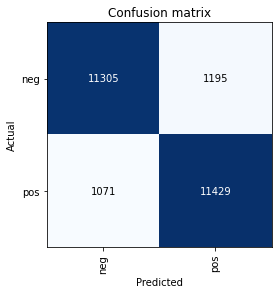

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

,input,target,predicted,probability,loss
0,"xxbos i really liked this quirky movie . xxmaj the characters are not the bland beautiful people that show up in so many movies and on xxup tv . xxmaj it has a realistic edge , with a captivating story line . xxmaj the main title sequence alone makes this movie fun to watch .",neg,pos,1.0,20.7421875
1,xxbos xxmaj this was a very nice concert by the one and only xxup mj . xxmaj the choreography was excellent and the costumes were decent . xxmaj the vocals were okay . i have to admit that his vocals were crap on xxmaj human xxmaj nature and xxmaj billie xxmaj jean . xxmaj you could n't hear him half the time . xxmaj the other songs make up for the singing . xxmaj the xxmaj highlights of the show are : xxmaj jam xxmaj smooth xxmaj criminal i xxmaj just xxmaj ca n't xxmaj stop xxmaj loving xxmaj you xxmaj she 's xxmaj out xxmaj of xxmaj my xxmaj life xxmaj thriller xxmaj billie xxmaj jean ( the xxmaj dancing xxmaj not xxmaj the xxmaj singing ) xxmaj black or xxmaj white xxmaj man in the xxmaj mirror xxmaj the concert was almost perfect . xxmaj if it was,neg,pos,1.0,19.5234375
2,"xxbos xxmaj this movie was pure genius . xxmaj john xxmaj waters is brilliant . xxmaj it is hilarious and i am not sick of it even after seeing it about 20 times since i bought it a few months ago . xxmaj the acting is great , although xxmaj ricki xxmaj lake could have been better . xxmaj and xxmaj johnny xxmaj depp is magnificent . xxmaj he is such a beautiful man and a very talented actor . xxmaj and seeing most of xxmaj johnny 's movies , this is probably my favorite . i give it 9.5 / 10 . xxmaj rent it today !",neg,pos,1.0,19.34375
3,"xxbos xxmaj to surmise , this film involves two actors ( caine and xxmaj moran ) trying to con a gangster . xxmaj the plot is flimsy at best as several plot holes occur throughout . xxmaj however this normally should n't matter as the comedy should carry a film like this . xxmaj there are some genuinely funny bits ( mostly provided by xxmaj dylan xxmaj moran ) . xxmaj however , other times , there are long melodramatic scenes that fail to add anything to the movie . xxmaj caine 's character seemed overdone to me . xxmaj especially at the start , he continually quotes xxmaj shakespeare and acts like a pompous actor . xxmaj one could say he was playing the part properly but the character seemed to me flat and unfunny . xxmaj overall i would say see only if a fan of the actors",pos,neg,1.0,18.4921875
4,"xxbos xxmaj this film has the language , the style and the attitude down … plus greats rides from xxmaj xxunk ( a world champ ) and the great xxmaj jerry xxmaj lopez . xxmaj john xxmaj philbin as xxmaj turtle has the surf pidgin down , and the surfing scenes are still the best ever . a true classic that can be seen many times . xxmaj nia xxmaj peeples is a babe , and xxmaj laird xxmaj hamilton shows the early stuff that has made him the world 's number one extreme surfer .",neg,pos,1.0,18.2890625
5,"xxbos xxmaj everything this film tried to do is done better - and superbly in "" run xxmaj lola xxmaj run "" . xxmaj the xxmaj red xxmaj haired xxmaj hip xxmaj cutie , the critical xxunk ) , xxmaj the xxmaj lover in jeopardy , and the "" crime pays - sometimes "" message . xxup but , unlike "" lola "" , it just is n't believable or well put together . xxmaj it is a labored knock off that might have worked for me if i had seen it before "" lola "" - but it pales in comparison . xxmaj yes ! xxmaj the xxmaj falling xxmaj beetle was nice ! xxmaj but that was about the only surprise in the film . xxmaj do yourself a favor and see the xxmaj real mccoy - ( and the xxup real hip xxmaj red xxmaj head !",neg,pos,1.0,18.15625
6,"xxbos xxmaj well , i must say , i initially found this short to be quite average , but having watched it nearly 5 times since ( its constantly shown on xxup ifc ) , xxmaj i 've developed an enjoyment of the simple plot elements and reality of the situations presented . xxma

# Disinformation and Language Models

Even simple algorithms based on rules, before the days of widely available deep learning language models, could be used to create fraudulent accounts and try to influence policymakers. Jeff Kao, now a computational journalist at ProPublica, analyzed the comments that were sent to the US Federal Communications Commission (FCC) regarding a 2017 proposal to repeal net neutrality. In his article ["More than a Million Pro-Repeal Net Neutrality Comments Were Likely Faked"](https://hackernoon.com/more-than-a-million-pro-repeal-net-neutrality-comments-were-likely-faked-e9f0e3ed36a6), he reports how he discovered a large cluster of comments opposing net neutrality that seemed to have been generated by some sort of Mad Libs-style mail merge. In <<disinformation>>, the fake comments have been helpfully color-coded by Kao to highlight their formulaic nature.

<img src="https://github.com/fastai/fastbook/blob/master/images/ethics/image16.png?raw=1" width="700" id="disinformation" caption="Comments received by the FCC during the net neutrality debate">

Kao estimated that "less than 800,000 of the 22M+ comments… could be considered truly unique" and that "more than 99% of the truly unique comments were in favor of keeping net neutrality."

Given advances in language modeling that have occurred since 2017, such fraudulent campaigns could be nearly impossible to catch now.  **You now have all the necessary tools at your disposal to create a compelling language model—that is, something that can generate context-appropriate, believable text. It won't necessarily be perfectly accurate or correct, but it will be plausible.** Think about what this technology would mean when put together with the kinds of disinformation campaigns we have learned about in recent years. Take a look at the Reddit dialogue shown in <<ethics_reddit>>, where a **language model based on OpenAI's GPT-2 algorithm is having a conversation with itself about whether the US government should cut defense spending.**

<img src="https://github.com/fastai/fastbook/blob/master/images/ethics/image14.png?raw=1" id="ethics_reddit" caption="An algorithm talking to itself on Reddit" alt="An algorithm talking to itself on Reddit" width="600">

In this case, it was explicitly said that an algorithm was used, but imagine what would happen if a bad actor decided to release such an algorithm across social networks. They could do it slowly and carefully, allowing the algorithm to gradually develop followers and trust over time. It would not take many resources to have literally millions of accounts doing this. **In such a situation we could easily imagine getting to a point where the vast majority of discourse online was from bots, and nobody would have any idea that it was happening.**

We are already starting to see examples of machine learning being used to generate identities. For example, <<katie_jones>> shows a **LinkedIn profile for Katie Jones.**

<img src="https://github.com/fastai/fastbook/blob/master/images/ethics/image15.jpeg?raw=1" width="400" id="katie_jones" caption="Katie Jones's LinkedIn profile">

Katie Jones was connected on LinkedIn to several members of mainstream Washington think tanks. But she didn't exist. That image you see was auto-generated by a generative adversarial network, and somebody named Katie Jones has not, in fact, graduated from the Center for Strategic and International Studies.

Many people assume or hope that algorithms will come to our defense here—that we will develop classification algorithms that can automatically recognise autogenerated content. The problem, however, is that this will always be an arms race, in which better classification (or discriminator) algorithms can be used to create better generation algorithms.

## Conclusion

In this chapter we explored the last application covered out of the box by the fastai library: text. We saw two types of models: language models that can generate texts, and a classifier that determines if a review is positive or negative. To build a state-of-the art classifier, we used a pretrained language model, fine-tuned it to the corpus of our task, then used its body (the encoder) with a new head to do the classification.

Before we end this section, we'll take a look at how the fastai library can help you assemble your data for your specific problems.

## Questionnaire

1. What is "self-supervised learning"?
> Training a model without the use of labels. An example is a language model.
1. What is a "language model"?
> A language model is a self-supervised model that tries to predict the next word of a given passage of text.
1. Why is a language model considered self-supervised?
> There are no labels (ex: sentiment) provided during training. Instead, the model learns to predict the next word by reading lots of provided text with no labels.
1. What are self-supervised models usually used for?
> Sometimes, they are used by themselves. For example, a language model can be used for autocomplete algorithms! But often, they are used as a pre-trained model for transfer learning.
1. Why do we fine-tune language models?
> We can fine-tune the language model on the corpus of the desired downstream task, since the original pre-trained language model was trained on a corpus that is slightly different than the one for the current task.
1. What are the three steps to create a state-of-the-art text classifier?
> - Train a language model on a large corpus of text (already done for ULM-FiT by Sebastian Ruder and Jeremy!)
> - Fine-tune the language model on text classification dataset
> - Fine-tune the language model as a text classifier instead.
1. How do the 50,000 unlabeled movie reviews help us create a better text classifier for the IMDb dataset?
> By learning how to predict the next word of a movie review, the model better understands the language style and structure of the text classification dataset and can, therefore, perform better when fine-tuned as a classifier.
1. What are the three steps to prepare your data for a language model?
> - Tokenization
> - Numericalization
> - Language model DataLoader
1. What is "tokenization"? Why do we need it?
> Tokenization is the process of converting text into a list of words. It is not as simple as splitting on the spaces. Therefore, we need a tokenizer that deals with complicated cases like punctuation, hyphenated words, etc.
> Also, tokenization is needed because we’re examining texts for patterns. It won’t be possible to find such patterns if we only consider a text at the sentence level, since patterns would only emerge if certain sentences frequently appeared together in sets, and this is a very rare phenomenon. Needless to say, examining texts in their entirety would be even less productive. We only find interesting patterns when we examine texts at the level of individual words, substrings, or individual characters.
1. Name three different approaches to tokenization.
> - Word-based tokenization
> - Subword-based tokenization
> - Character-based tokenization
1. What is `xxbos`?
> This is a special token added by fastai that indicated the beginning of the text (beginning of sequence).
1. List four rules that fastai applies to text during tokenization.
> Here are all the rules:
> - fix_html :: replace special HTML characters by a readable version (IMDb reviews have quite a few of them for instance) ;
> - replace_rep :: replace any character repeated three times or more by a special token for repetition (xxrep), the number of times it’s repeated, then the character ;
> - replace_wrep :: replace any word repeated three times or more by a special token for word repetition (xxwrep), the number of times it’s repeated, then the word ;
> - spec_add_spaces :: add spaces around / and # ;
> - rm_useless_spaces :: remove all repetitions of the space character ;
replace_all_caps :: lowercase a word written in all caps and adds a special token for all caps (xxcap) in front of it ;
> - replace_maj :: lowercase a capitalized word and adds a special token for capitalized (xxmaj) in front of it ;
> - lowercase :: lowercase all text and adds a special token at the beginning (xxbos) and/or the end (xxeos).
1. Why are repeated characters replaced with a token showing the number of repetitions and the character that's repeated?
> We can expect that repeated characters could have special or different meaning than just a single character. By replacing them with a special token showing the number of repetitions, the model’s embedding matrix can encode information about general concepts such as repeated characters rather than requiring a separate token for every number of repetitions of every character.
1. What is "numericalization"?
> This refers to the mapping of the tokens to integers to be passed into the model.
1. Why might there be words that are replaced with the "unknown word" token?
> If all the words in the dataset have a token associated with them, then the embedding matrix will be very large, increase memory usage, and slow down training. Therefore, only words with more than min_freq occurrence are assigned a token and finally a number, while others are replaced with the “unknown word” token.
1. With a batch size of 64, the first row of the tensor representing the first batch contains the first 64 tokens for the dataset. What does the second row of that tensor contain? What does the first row of the second batch contain? (Careful—students often get this one wrong! Be sure to check your answer on the book's website.)
> - a. The dataset is split into 64 mini-streams (batch size)
> - b. Each batch has 64 rows (batch size) and 64 columns (sequence length)
> - c. The first row of the first batch contains the beginning of the first mini-stream (tokens 1-64)
> - d. The second row of the first batch contains the beginning of the second mini-stream
> - e. The first row of the second batch contains the second chunk of the first mini-stream (tokens 65-128)
1. Why do we need padding for text classification? Why don't we need it for language modeling?
> Since the documents have variable sizes, padding is needed to collate the batch. Other approaches. like cropping or squishing, either to negatively affect training or do not make sense in this context. Therefore, padding is used. It is not required for language modeling since the documents are all concatenated.
1. What does an embedding matrix for NLP contain? What is its shape?
> It contains vector representations of all tokens in the vocabulary. The embedding matrix has the size (vocab_size x embedding_size), where vocab_size is the length of the vocabulary, and embedding_size is an arbitrary number defining the number of latent factors of the tokens.
1. What is "perplexity"?
> Perplexity is a commonly used metric in NLP for language models. It is the exponential of the loss.
1. Why do we have to pass the vocabulary of the language model to the classifier data block?
> This is to ensure the same correspondence of tokens to index so the model can appropriately use the embeddings learned during LM fine-tuning.
1. What is "gradual unfreezing"?
> This refers to unfreezing one layer at a time and fine-tuning the pretrained model.
1. Why is text generation always likely to be ahead of automatic identification of machine-generated texts?
> The classification models could be used to improve text generation algorithms (evading the classifier) so the text generation algorithms will always be ahead.

### Further Research

1. See what you can learn about language models and disinformation. What are the best language models today? Take a look at some of their outputs. Do you find them convincing? How could a bad actor best use such a model to create conflict and uncertainty?
1. Given the limitation that models are unlikely to be able to consistently recognize machine-generated texts, what other approaches may be needed to handle large-scale disinformation campaigns that leverage deep learning?

# Readings
- [fastai NLP](https://nlp.fast.ai/)
- [ULMFiT paper](https://arxiv.org/pdf/1801.06146.pdf)- [Attention is all you need](https://arxiv.org/abs/1706.03762)
- [fastai-transformers tutorial](https://docs.fast.ai/tutorial.transformers.html)
- [fastai+transformers](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2)

- [Understanding fastai `fit_one_cycle`](https://iconof.com/1cycle-learning-rate-policy/)

- [The state of transfer learning in NLP](https://ruder.io/state-of-transfer-learning-in-nlp/)

# NLP Blogs
Good NLP-related blogs:

- [Sebastian Ruder](https://ruder.io/); [NLP newsletter](https://newsletter.ruder.io/)
- [Joyce Xu](https://www.joycexu.io/)
- [Jay Alammar](https://jalammar.github.io/)
- [Stephen Merity](https://state.smerity.com/)
- [Rachael Tatman](http://www.rctatman.com/)